In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import keras.src.saving
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [4]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

In [5]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [6]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


In [7]:
fixed_noise = tf.random.normal((60, 1024))

In [43]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
# show_images(X_train)

In [9]:
from keras import ops
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_discriminator():
    Discriminator = Sequential([
        layers.Conv2D(256, kernel_size = (3, 3), strides = 2, padding = 'same', input_shape = (128, 128, 3)),
        layers.LeakyReLU(),
    
        layers.Conv2D(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Flatten(),
        layers.Dense(1)
    ])
    return Discriminator

In [11]:
Discriminator = build_discriminator()
Discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,153 (1.50 MB)

 Trainable params: 392,769 (1.50 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
def build_generator():
    Generator = Sequential([
        layers.Dense(8 * 8 * 128, input_shape = (1024,)),
        layers.LeakyReLU(),
    
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Conv2DTranspose(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
    
        layers.Conv2DTranspose(32, kernel_size = (3, 3), strides = 2, padding = 'same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(3, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'sigmoid'),
    ])
    return Generator

In [13]:
Generator = build_generator()
Generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,638,403 (32.95 MB)

 Trainable params: 8,637,955 (32.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
class EDGAN(Model):
    def __init__(self, Generator, Discriminator, encoder, decoder):
        super().__init__()
        self.latent_dim = 1024
        self.generator = Generator
        self.discriminator = Discriminator
        self.encoder = encoder
        self.decoder = decoder
        # print(self.generator.model.summary())
    def compile(self, gen_optimizer, disc_optimizer, criterion):
        super().compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    # def train_step(self, images):
    #     # Get the data
    #     real_images = images
    #     noise = self._generate_noise()
    # 
    #     # Train the discriminator and generator
    #     return self._train_step(real_images, noise)
    # 
    # def _generate_noise(self):
    #     noise = tf.random.normal((256, self.latent_dim, 1))
    #     noise = self.decoder(noise)
    #     noise = self.encoder(noise)[2]
    #     noise = tf.convert_to_tensor(noise)
    #     return noise
    
    @tf.function
    def train_step(self, real_images):
        noise = tf.random.normal((256, self.latent_dim))
        noise = self.decoder(noise)
        noise = self.encoder(noise)[2]
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = tf.convert_to_tensor(noise)
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}

In [15]:
def build_model(model_name):
    # clear the session for a clean run
    keras.backend.clear_session()
    vae_encoder = model_folder + "/" + model_name + "_encoder.h5"
    vae_decoder = model_folder + "/" + model_name + "_decoder.h5"
    encoder = keras.src.saving.load_model(vae_encoder, custom_objects={'Sampling': Sampling}, compile=False)
    decoder = keras.src.saving.load_model(vae_decoder, compile=False)
    Generator = build_generator()
    Discriminator = build_discriminator()
    edgan_model = EDGAN(Generator, Discriminator, encoder, decoder)
    edgan_model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  criterion = tf.keras.losses.BinaryCrossentropy(True))
    
    return edgan_model

In [16]:
def save_model(model, model_name):
    generator_path = model_folder + "/" + model_name + "_encoder.h5"
    discriminator_path = model_folder + "/" + model_name + "_decoder.h5"
    model_path = model_folder + "/" + model_name + "_model.h5"
    model.generator.save(generator_path)
    model.discriminator.save(discriminator_path)
    model.save(model_path)

In [17]:
import matplotlib.pyplot as plt
import json

def show_history(history, model_name):
    plt.plot(history.history['Generator Loss'])
    plt.plot(history.history['Discriminator Loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [18]:
caries_edgan = build_model("fyp_caries_vae1024")
caries_edgan_history = caries_edgan.fit(caries, epochs = 1000, batch_size = 50)
save_model(caries_edgan, "fyp_caries_EDGAN1024")

Epoch 1/1000


I0000 00:00:1716815599.273873  131961 service.cc:145] XLA service 0x72ff7401a4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716815599.273894  131961 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1716815600.773466  131997 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 188 bytes spill stores, 188 bytes spill loads

I0000 00:00:1716815600.892535  131999 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 660 bytes spill stores, 848 bytes spill loads

I0000 00:00:1716815629.916448  131961 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - Discriminator Loss: 2.0758 - Generator Loss: 0.6472
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - Discriminator Loss: 2.2460 - Generator Loss: 0.2698
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - Discriminator Loss: 2.7626 - Generator Loss: 0.1535
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - Discriminator Loss: 3.0447 - Generator Loss: 0.1323
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - Discriminator Loss: 3.2046 - Generator Loss: 0.1314
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - Discriminator Loss: 3.1295 - Generator Loss: 0.1502
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - Discriminator Loss: 3.1644 - Generator Loss: 0.1824
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - Discriminator Loss: 2.8304 - Generator Loss: 0.2399
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - Discriminator Loss: 2.9243 - Generator Loss: 0.3035
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - Discr

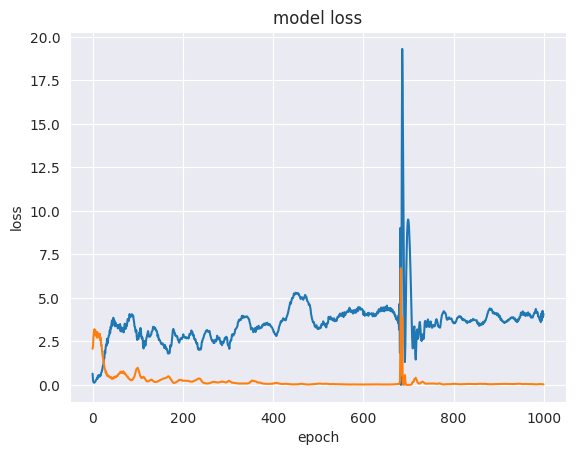

In [19]:
show_history(caries_edgan_history, "fyp_caries_EDGAN1024")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step


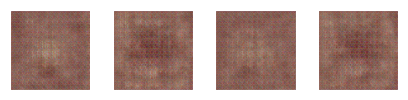

In [20]:
fixed_noise
y_pred = caries_edgan.generator.predict(fixed_noise)
show_images(y_pred)

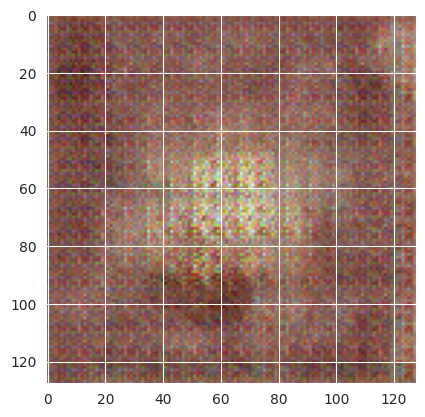

In [21]:
plt.imshow(y_pred[10])

In [22]:
gingivitis_edgan = build_model("fyp_gingivitis_vae1024")
gingivitis_edgan_history = gingivitis_edgan.fit(gingivitis, epochs = 1000, batch_size = 50)
save_model(gingivitis_edgan, "fyp_gingivitis_EDGAN1024")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - Discriminator Loss: 1.9408 - Generator Loss: 0.9607
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - Discriminator Loss: 2.3506 - Generator Loss: 0.2770
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - Discriminator Loss: 2.8582 - Generator Loss: 0.1683
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - Discriminator Loss: 3.3145 - Generator Loss: 0.1032
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - Discriminator Loss: 3.3479 - Generator Loss: 0.1081
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - Discriminator Loss: 3.2638 - Generator Loss: 0.1387
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - Discriminator Loss: 3.1085 - Generator Loss: 0.1588
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - Discriminator Loss: 2.8226 - Generator Loss: 0.2506
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - Discriminator Loss: 2.7017 - Generator Loss: 0.3318
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/s

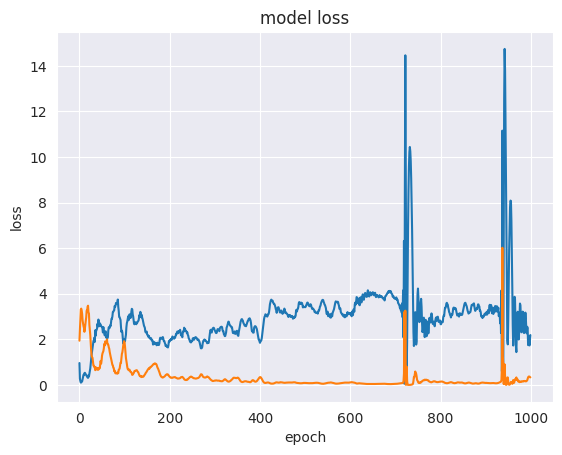

In [23]:
show_history(gingivitis_edgan_history, "fyp_gingivitis_EDGAN1024")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


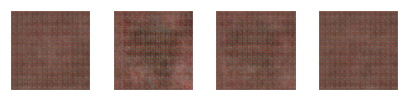

In [24]:
y_pred = gingivitis_edgan.generator.predict(fixed_noise)
show_images(y_pred)

In [25]:
wsl_edgan = build_model("fyp_wsls_vae1024")
wsl_edgan_history = wsl_edgan.fit(wsl, epochs = 1000, batch_size = 50)
save_model(wsl_edgan, "fyp_wsls_EDGAN1024")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Discriminator Loss: 1.5497 - Generator Loss: 1.1137
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - Discriminator Loss: 2.5784 - Generator Loss: 0.2002
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - Discriminator Loss: 3.8575 - Generator Loss: 0.0574
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - Discriminator Loss: 4.4204 - Generator Loss: 0.0412
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - Discriminator Loss: 4.2853 - Generator Loss: 0.0497
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - Discriminator Loss: 4.3334 - Generator Loss: 0.0512
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - Discriminator Loss: 3.9291 - Generator Loss: 0.1033
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - Discriminator Loss: 3.6319 - Generator Loss: 0.1403
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - Discriminator Loss: 3.2107 - Generator Loss: 0.2500
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/s

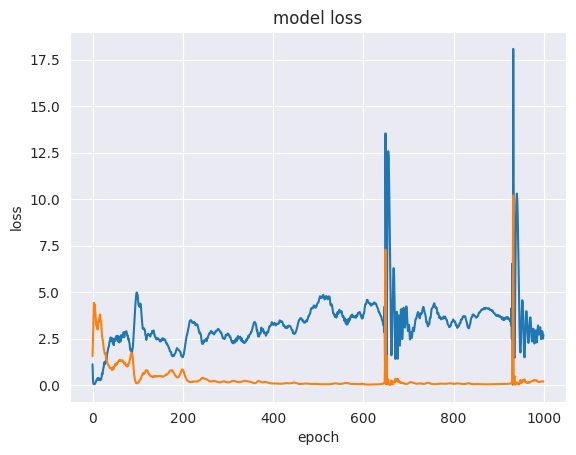

In [26]:
show_history(wsl_edgan_history, "fyp_wsl_EDGAN1024")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x72ffa0465750> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


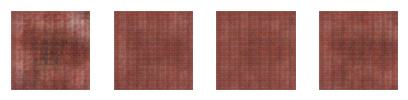

In [27]:
y_pred = wsl_edgan.generator.predict(fixed_noise)
show_images(y_pred)

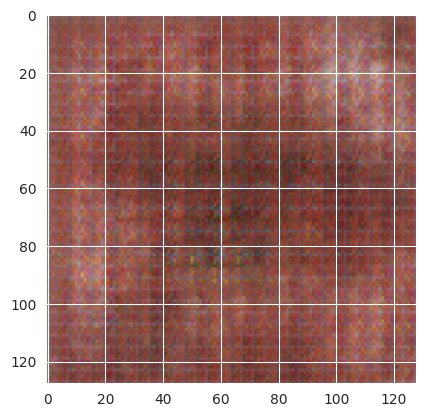

In [28]:
plt.imshow(y_pred[0])

In [29]:
test = tf.random.normal((256, 1024))

In [30]:
type(test)

tensorflow.python.framework.ops.EagerTensor

In [31]:
print(test.shape)

(256, 1024)


In [32]:
test

<tf.Tensor: shape=(256, 1024), dtype=float32, numpy=
array([[ 0.3274685 , -0.8426258 ,  0.3194337 , ...,  0.5278292 ,
         1.1856552 ,  1.9907517 ],
       [-0.5677412 ,  0.06361793,  0.87650114, ..., -0.028244  ,
         0.8657619 , -1.029675  ],
       [ 0.3453135 ,  0.7186727 ,  0.836676  , ..., -0.15449814,
        -1.5067958 ,  0.05030049],
       ...,
       [ 0.29803213, -1.2013458 , -1.262496  , ...,  1.0837847 ,
        -0.5780578 ,  0.56044203],
       [ 1.3861827 , -0.4218264 ,  0.43974882, ..., -0.5299534 ,
         0.95337707, -0.59526455],
       [ 0.34058285,  0.6047567 ,  1.2642066 , ..., -0.83287615,
        -0.95538867,  1.0012758 ]], dtype=float32)>

In [33]:
model_name = 'fyp_caries_vae1024'
vae_encoder = model_folder + "/" + model_name + "_encoder.h5"
vae_decoder = model_folder + "/" + model_name + "_decoder.h5"
encoder = keras.src.saving.load_model(vae_encoder, custom_objects={'Sampling': Sampling}, compile=False)
decoder = keras.src.saving.load_model(vae_decoder, compile=False)

In [34]:
test1 = decoder.predict(test)
test2 = encoder.predict(test1)[2]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


I0000 00:00:1716816441.771044  181274 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 188 bytes spill stores, 188 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [35]:
test2.shape

(256, 1024)

In [36]:
test2

array([[ 0.32942623, -0.64249873,  1.7096391 , ...,  0.59309256,
        -0.95756155, -0.42637068],
       [-0.8744874 ,  0.37511688, -0.7244221 , ...,  0.42688745,
        -0.46422395,  0.26474077],
       [-0.13612801,  1.049052  , -0.443368  , ...,  0.3541459 ,
         0.92147636, -0.23362768],
       ...,
       [-0.33766192,  0.6202599 , -0.45782003, ..., -1.7290041 ,
        -1.1960413 , -0.20783825],
       [ 1.550294  ,  1.3241141 , -1.4691164 , ..., -1.9204209 ,
         0.24903598, -1.4741447 ],
       [ 1.0398693 ,  2.4238183 ,  0.46026364, ...,  1.9394894 ,
         0.83919585,  0.447541  ]], dtype=float32)

In [37]:
test3 = tf.convert_to_tensor(test2)

In [38]:
test3

<tf.Tensor: shape=(256, 1024), dtype=float32, numpy=
array([[ 0.32942623, -0.64249873,  1.7096391 , ...,  0.59309256,
        -0.95756155, -0.42637068],
       [-0.8744874 ,  0.37511688, -0.7244221 , ...,  0.42688745,
        -0.46422395,  0.26474077],
       [-0.13612801,  1.049052  , -0.443368  , ...,  0.3541459 ,
         0.92147636, -0.23362768],
       ...,
       [-0.33766192,  0.6202599 , -0.45782003, ..., -1.7290041 ,
        -1.1960413 , -0.20783825],
       [ 1.550294  ,  1.3241141 , -1.4691164 , ..., -1.9204209 ,
         0.24903598, -1.4741447 ],
       [ 1.0398693 ,  2.4238183 ,  0.46026364, ...,  1.9394894 ,
         0.83919585,  0.447541  ]], dtype=float32)>

In [39]:
test3[0]

<tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.32942623, -0.64249873,  1.7096391 , ...,  0.59309256,
       -0.95756155, -0.42637068], dtype=float32)>

In [40]:
test[0]

<tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.3274685, -0.8426258,  0.3194337, ...,  0.5278292,  1.1856552,
        1.9907517], dtype=float32)>

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


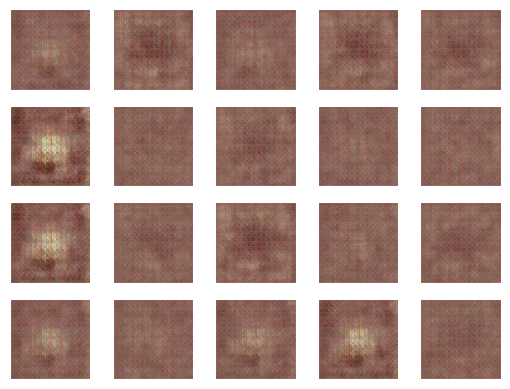

In [44]:
y_pred = caries_edgan.generator.predict(fixed_noise)
show_images(y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


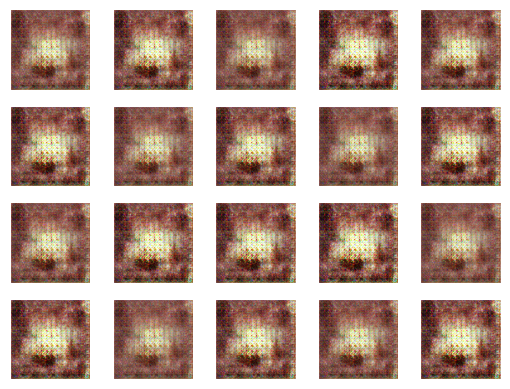

In [45]:
y_pred = caries_edgan.generator.predict(test3)
show_images(y_pred)

In [48]:
test3[0]

<tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.32942623, -0.64249873,  1.7096391 , ...,  0.59309256,
       -0.95756155, -0.42637068], dtype=float32)>

In [49]:
test3[1]

<tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([-0.8744874 ,  0.37511688, -0.7244221 , ...,  0.42688745,
       -0.46422395,  0.26474077], dtype=float32)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


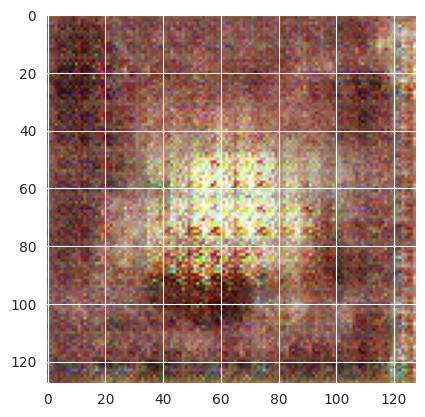

In [68]:
trry = tf.convert_to_tensor(test2[0].reshape(1, 1024))
trry = caries_edgan.generator.predict(trry)
plt.imshow(trry[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


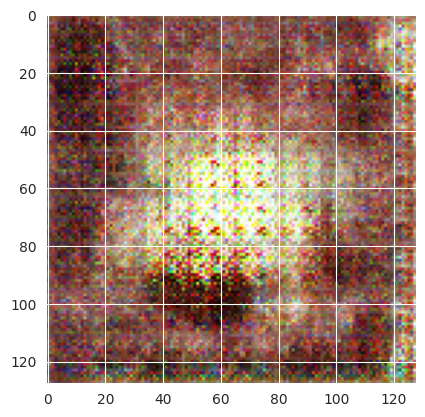

In [70]:
trry = tf.convert_to_tensor(test2[250].reshape(1, 1024))
trry = caries_edgan.generator.predict(trry)
plt.imshow(trry[0])